In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#train_data = pd.read_csv('/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_train.csv')
#train_data_new = train_data[train_data['body'].notnull()]

#test_data = pd.read_csv("/content/drive/MyDrive/metin_madenciligi_proje/preprocessed_european_comments_test.csv")
#test_data_new = test_data[test_data['body'].notnull()]

data = pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2013_gezi/preprocessed_twitter_2013_gezi.csv')

In [7]:
data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,10k yellow gold blue colored. blue cluster col...,0.040000,0.000000,Neutral
1,1,14k yellow/white gold 0.04 ct. diamond 7 004 d...,0.000000,0.000000,Neutral
2,2,stop 3qt red sand scoop{ special } free shovel...,0.457143,0.252381,Positive
3,3,"solid report claims iphone 5s available gold, ...",0.318182,0.178788,Positive
4,4,gold boss chain necklace fashion accessories shop,0.000000,0.000000,Neutral


In [8]:
#combined_data = train_data.append(test_data, ignore_index=True)
data.shape

(22254, 5)

In [9]:
data["Analysis"].value_counts()

Neutral     13345
Positive     6486
Negative     2423
Name: Analysis, dtype: int64

In [10]:
tokenized_data = data['tweet'].apply(lambda x: str(x).split()) # tokenizing

In [11]:
tokenized_data

0        [10k, yellow, gold, blue, colored., blue, clus...
1        [14k, yellow/white, gold, 0.04, ct., diamond, ...
2        [stop, 3qt, red, sand, scoop{, special, }, fre...
3        [solid, report, claims, iphone, 5s, available,...
4        [gold, boss, chain, necklace, fashion, accesso...
                               ...                        
22249    [2.75, carat, citrine, diamond, cocktail, ring...
22250    [1.25, carat, (ctw), sterling, silver, round, ...
22251    [1.50, carat, ctw, 6, mm, real, natural, genui...
22252    [blue, topaz, tear, drop, earrings, 7, carat, ...
22253    [wellen, brillantenring, 0.12, carat, gelbgold...
Name: tweet, Length: 22254, dtype: object

In [12]:
from gensim.models import Word2Vec

In [13]:
model_w2v = Word2Vec(tokenized_data, size=256,  window=5)
model_w2v.train(tokenized_data, total_examples= len(tokenized_data), epochs=10)

(2051352, 2315010)

In [14]:
model_w2v.wv.most_similar(positive="gold")

[('key!', 0.6167811155319214),
 ('50k', 0.6008752584457397),
 ('beta', 0.5950448513031006),
 ('drive', 0.5870118737220764),
 ('sick', 0.5734694004058838),
 ('hearthstone', 0.5706074833869934),
 ('warcraft', 0.5643603205680847),
 ('allgoldeverythinggold', 0.5546996593475342),
 ('flash', 0.5492256879806519),
 ('pegs', 0.538463830947876)]

In [15]:
# EEZ: Exclusive Economic Zone (Münhasır Ekonomik Bölge)
model_w2v.wv.most_similar(positive="exchange")

[('project', 0.7275654077529907),
 ('writing', 0.7159744501113892),
 ('exchange»', 0.7141696810722351),
 ('structure', 0.6893050670623779),
 ('conceptdraw', 0.6877577304840088),
 ('windowsserver', 0.6870850324630737),
 ('based', 0.6856564283370972),
 ('ukjobs', 0.6812950372695923),
 ('dorset', 0.675217866897583),
 ('hyperv', 0.6723527908325195)]

In [16]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [17]:
wordvec_arrays = np.zeros((len(tokenized_data), 256))

for i in range(len(data)):
    wordvec_arrays[i,:] = word_vector(tokenized_data[i], 256)

wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

<ipython-input-16-2f6882f45f7b>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec += model_w2v[word].reshape((1, size))


(22254, 256)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
#train_w2v = wordvec_df.iloc[:56819,:]
#test_w2v = wordvec_df.iloc[56819:,:]

X_train, x_test, y_train, y_valid = train_test_split(wordvec_df, data['Analysis'],  
                                                          random_state=42, 
                                                          test_size=0.2)

#print(train_w2v.shape, data['Analysis'].shape)

#xtrain_w2v = train_w2v.iloc[y_train.index,:]
#xvalid_w2v = train_w2v.iloc[y_valid.index,:]

In [20]:
X_train.shape

(17803, 256)

In [21]:
x_test.shape

(4451, 256)

In [22]:
y_train.shape

(17803,)

In [23]:
y_train

2678      Neutral
6151      Neutral
15491     Neutral
16945    Positive
7834      Neutral
           ...   
11964     Neutral
21575    Negative
5390     Negative
860       Neutral
15795    Positive
Name: Analysis, Length: 17803, dtype: object

In [24]:
y_valid.shape

(4451,)

In [25]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_valid)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [26]:
train_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [27]:
test_labels.shape

(4451, 3)

In [28]:
import tensorflow as tf
import keras.layers as layers
from keras.models import Model
from keras import models
import keras.losses

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input,Embedding,Dense,Flatten
from tensorflow.keras.metrics import AUC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

epochs = 50
batch_size = 256
optimizer = "adam"
metrics = ["categorical_crossentropy", AUC(name='auc')]

# Build neural network
model = models.Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics= metrics)

history = model.fit(X_train, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(x_test, test_labels))

Epoch 1/50
70/70 [==============================] - 3s 9ms/step - loss: 0.7397 - categorical_crossentropy: 0.7397 - auc: 0.8529 - val_loss: 0.5521 - val_categorical_crossentropy: 0.5521 - val_auc: 0.9206
Epoch 2/50
70/70 [==============================] - 0s 5ms/step - loss: 0.4505 - categorical_crossentropy: 0.4505 - auc: 0.9483 - val_loss: 0.3728 - val_categorical_crossentropy: 0.3728 - val_auc: 0.9644
Epoch 3/50
70/70 [==============================] - 0s 5ms/step - loss: 0.3166 - categorical_crossentropy: 0.3166 - auc: 0.9746 - val_loss: 0.2696 - val_categorical_crossentropy: 0.2696 - val_auc: 0.9813
Epoch 4/50
70/70 [==============================] - 0s 5ms/step - loss: 0.2364 - categorical_crossentropy: 0.2364 - auc: 0.9854 - val_loss: 0.2050 - val_categorical_crossentropy: 0.2050 - val_auc: 0.9895
Epoch 5/50
70/70 [==============================] - 0s 5ms/step - loss: 0.1796 - categorical_crossentropy: 0.1796 - auc: 0.9912 - val_loss: 0.1547 - val_categorical_crossentropy: 0.154

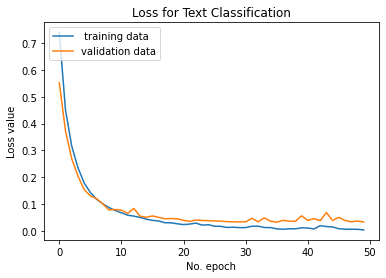

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

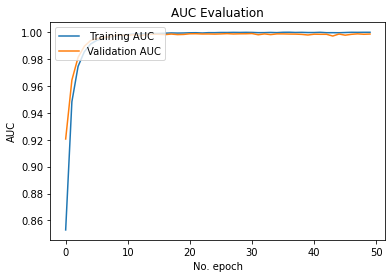

In [30]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [31]:
y__pred = model.predict(x_test)


140/140 [==============================] - 0s 1ms/step


In [32]:
y__pred.shape

(4451, 3)

In [33]:
y__pred = np.where((y__pred == 0),'Negative', y__pred)
y__pred = np.where((y__pred == '1'),'Neutral', y__pred)
y__pred = np.where((y__pred == '2'),'Positive', y__pred)

In [34]:
y_valid.shape

(4451,)

In [35]:
print(classification_report(data.Analysis, y__pred))

ValueError: ignored